<a href="https://colab.research.google.com/github/S-H-H-Homami/Audio-Classification/blob/main/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music / Speech Classification

## Downloading Audio Data

Data used for training consists of 2 class of audio waves which are "Music" or "Speech".

In [1]:
import tensorflow as tf
from tensorflow import keras


Data is uploaded manualy, seperated in two folders: "music_wav" and "speech_wav".
First, we create a dataframe for files names and their folder names for further uses.

## Preprocessing

In [2]:
#Getting a list of files names in each folder
import os
music_files_names= os.listdir("/content/music_wav")
speech_files_names= os.listdir("/content/speech_wav")

In [3]:
import pandas as pd

#Creating a dataframe for each folder

music_df= pd.DataFrame(music_files_names, columns= ["File"])
music_df['Label']= "music_wav"


speech_df= pd.DataFrame(speech_files_names, columns= ["File"])
speech_df['Label']= "speech_wav"


#Joining two dataframes 
join = [music_df, speech_df]
dataframe = pd.concat(join)

dataframe.head()

,File,Label
0,ballad.wav,music_wav
1,blues.wav,music_wav
2,birdland.wav,music_wav
3,beat.wav,music_wav
4,bagpipe.wav,music_wav


In [4]:

#Creating file paths
for index in dataframe:
  dataframe['Path']= "/content/Shuffle/"+ dataframe['File']



In [5]:
#Shuffling our dataframe
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
dataframe.head()

,File,Label,Path
0,stupid.wav,speech_wav,/content/drive/MyDrive/GoalEarn/Third Task/Shu...
1,gravity.wav,music_wav,/content/drive/MyDrive/GoalEarn/Third Task/Shu...
2,bmarsalis.wav,music_wav,/content/drive/MyDrive/GoalEarn/Third Task/Shu...
3,comedy1.wav,speech_wav,/content/drive/MyDrive/GoalEarn/Third Task/Shu...
4,march.wav,music_wav,/content/drive/MyDrive/GoalEarn/Third Task/Shu...


Decoding audio files

In [6]:
def decode(path):
  file = tf.io.read_file(path)
  audio, sample_rate = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)
  audio = tf.cast(audio, tf.float32)
  return audio

In [7]:
def sample_rate(path):
  file = tf.io.read_file(path)
  audio, sample_rate = tf.audio.decode_wav(file)
  return sample_rate

Spectrogram

In [8]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 1

In [9]:
def spect(audio):
  spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
# #normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)
  return spectrogram

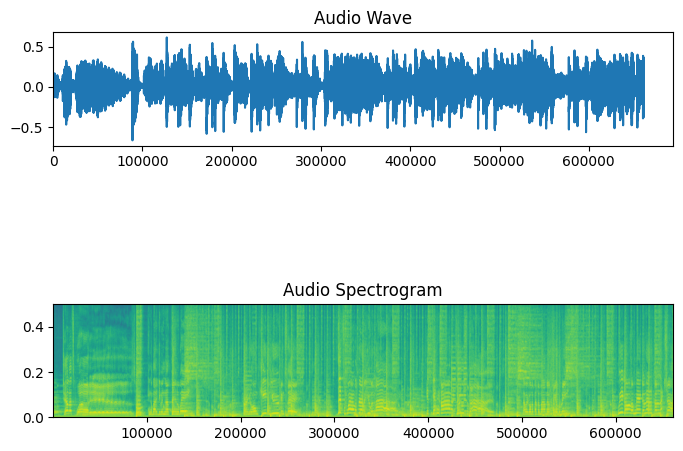

In [10]:
from matplotlib import pyplot as plt
import numpy as np

sample= 1
path= dataframe['Path'][sample]
fig = plt.figure(figsize=(8, 5))


plt.subplot(3,1,1)
plt.title("Audio Wave")
plt.plot(decode(path))
plt.xlim(left=0)




plt.subplot(3,1,3)
plt.title("Audio Spectrogram")
plt.specgram(decode(path), Fs= frame_step)


plt.show()


Creating Dataset

In [11]:
from pathlib import Path

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):

        waveform = decode(file_path)
        s_rate= sample_rate(file_path)
        dataset.append([waveform, s_rate, label])
        
    return dataset

In [12]:
trainset_music = load_audio_files('/content/music_wav', 'MUSIC')
trainset_speech = load_audio_files('/content/speech_wav', 'SPEECH')

print(f'Length of MUSIC dataset: {len(trainset_music)}')
print(f'Length of SPEECH dataset: {len(trainset_speech)}')

Length of MUSIC dataset: 64
Length of SPEECH dataset: 64


In [13]:
def create_images_plt(dataset, label_dir, border):
    # make directory
    test_directory = f'/content/test_plt/{label_dir}/'
    val_directory = f'/content/val_plt/{label_dir}/'
    train_directory = f'/content/train_plt/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    os.makedirs(val_directory, mode=0o777, exist_ok=True)
    
    for i, data in enumerate(dataset):

        waveform = data[0]
        # spectrogram = spect(waveform)
        plt.specgram(waveform, Fs= frame_step)

        # Split test and train images by "border"
        if i % int(1/(1-border)) == 0:
          if i % int(2/(1-border)) == 0:
            plt.savefig(f'/content/val_plt/{label_dir}/spec_img{i}.png')
          else:
            plt.savefig(f'/content/test_plt/{label_dir}/spec_img{i}.png')
        else:
            plt.savefig(f'/content/train_plt/{label_dir}/spec_img{i}.png')

        


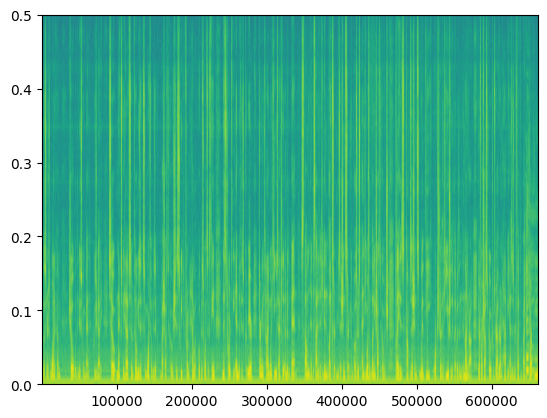

In [14]:
border= 0.8

create_images_plt(trainset_music, 'MUSIC', border)
create_images_plt(trainset_speech, 'SPEECH', border)

In [15]:
train_directory = '/content/train_plt/'
test_directory = '/content/test_plt/'
val_directory = '/content/val_plt/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123, shuffle= True, batch_size= 128)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None, shuffle= True, batch_size= 128)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None, shuffle= True, batch_size= 128)

class_names = train_ds.class_names
print(class_names)

Found 102 files belonging to 2 classes.
Found 12 files belonging to 2 classes.
Found 14 files belonging to 2 classes.
['MUSIC', 'SPEECH']


## Create the model

In [22]:
num_classes = 2
img_height = 256
img_width = 256

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 262144)           

Setting Hyperparameters and metrics:

In [24]:
learning_rate = 0.00001
epochs = 5000

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']

model.compile(loss=loss_fn, metrics=metrics, optimizer= optimizer)

## Train the model

In [25]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', verbose=1, patience=150)

history = model.fit(train_ds, epochs=epochs, callbacks=[es], validation_data= val_ds, batch_size= 128)

Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5000
1/1 [==============================] - 1s 917ms/step - loss: 0.6935 - accuracy: 0.4902 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5000
1/1 [==============================] - 1s 836ms/step - loss: 0.6927 - accuracy: 0.5098 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5000
1/1 [==============================] - 1s 874ms/step - loss: 0.6924 - accuracy: 0.5490 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5000
1/1 [==============================] - 1s 1s/step - loss: 0.6916 - accuracy: 0.5686 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/5000
1/1 [==============================] - 1s 1s/step - loss: 0.6945 - accuracy: 0.5196 - val_loss: 0.6918 - val_accuracy: 0.5714
Epoch 7/5000
1/1 [==============================] - 1s 1s/step - loss: 0.6947 - accuracy: 0.5686 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 8/5000
1/1 [

## Model Evaluation

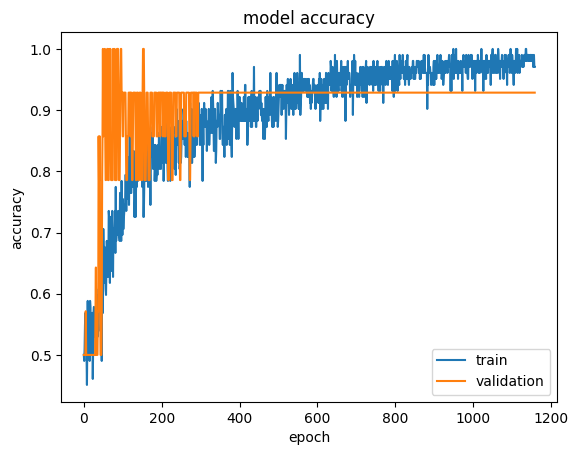

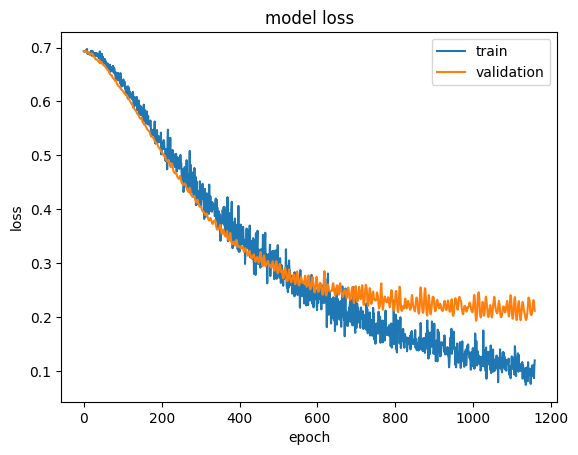

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [27]:
correct = 0
batch_size = 0
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    pred = model.predict(X)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    break

print(f'Number correct: {correct} out of {batch_size}')
print(f'Accuracy {correct / batch_size}')

1/1 [==============================] - 0s 97ms/step
Number correct: 12 out of 12
Accuracy 1.0


## Save model and architecture to single file

In [28]:
model.save("model.h5")